In [58]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import ticker, patheffects
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import swiftascmaps as swift
import xarray as xr

In [59]:
# Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    outline_effect = [patheffects.withStroke(linewidth=2.5, foreground='black')]

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        A = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        A.set_path_effects(outline_effect)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        B = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        B.set_path_effects(outline_effect)

In [60]:
#Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_Pressure Levels.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 20, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 100 150 200 250 300 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 07:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [61]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats) 

# Select and grab data
geop = ds['z'] 
geop_w_units = geop * units('m ** 2 / s ** 2')
z = mpcalc.geopotential_to_height(geop_w_units)
uwnd = ds['u']
vwnd = ds['v']

# Select and grab 500-hPa geopotential heights and wind components. 
# Add temperatures at 850 hPa and smooth with gaussian_filter.
hght_500 = gaussian_filter(z.sel(level=500).data[30], sigma=3.0) * units('m')
hght_dam = hght_500.to(units.decameter) #dam units
uwnd_500 = gaussian_filter(uwnd.sel(level=500).data[30], sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(vwnd.sel(level=500).data[30], sigma=3.0) * units('m/s')

# Calculate Vertical Vorticity
avor = mpcalc.vorticity(uwnd_500, vwnd_500, dx=dx, dy=dy)

# Calculate Advection
vort_adv = mpcalc.advection(scalar=avor, u=uwnd_500, v=vwnd_500, dx=dx, dy=dy) 

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
sped_500 = mpcalc.wind_speed(uwnd_500, vwnd_500).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[30].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

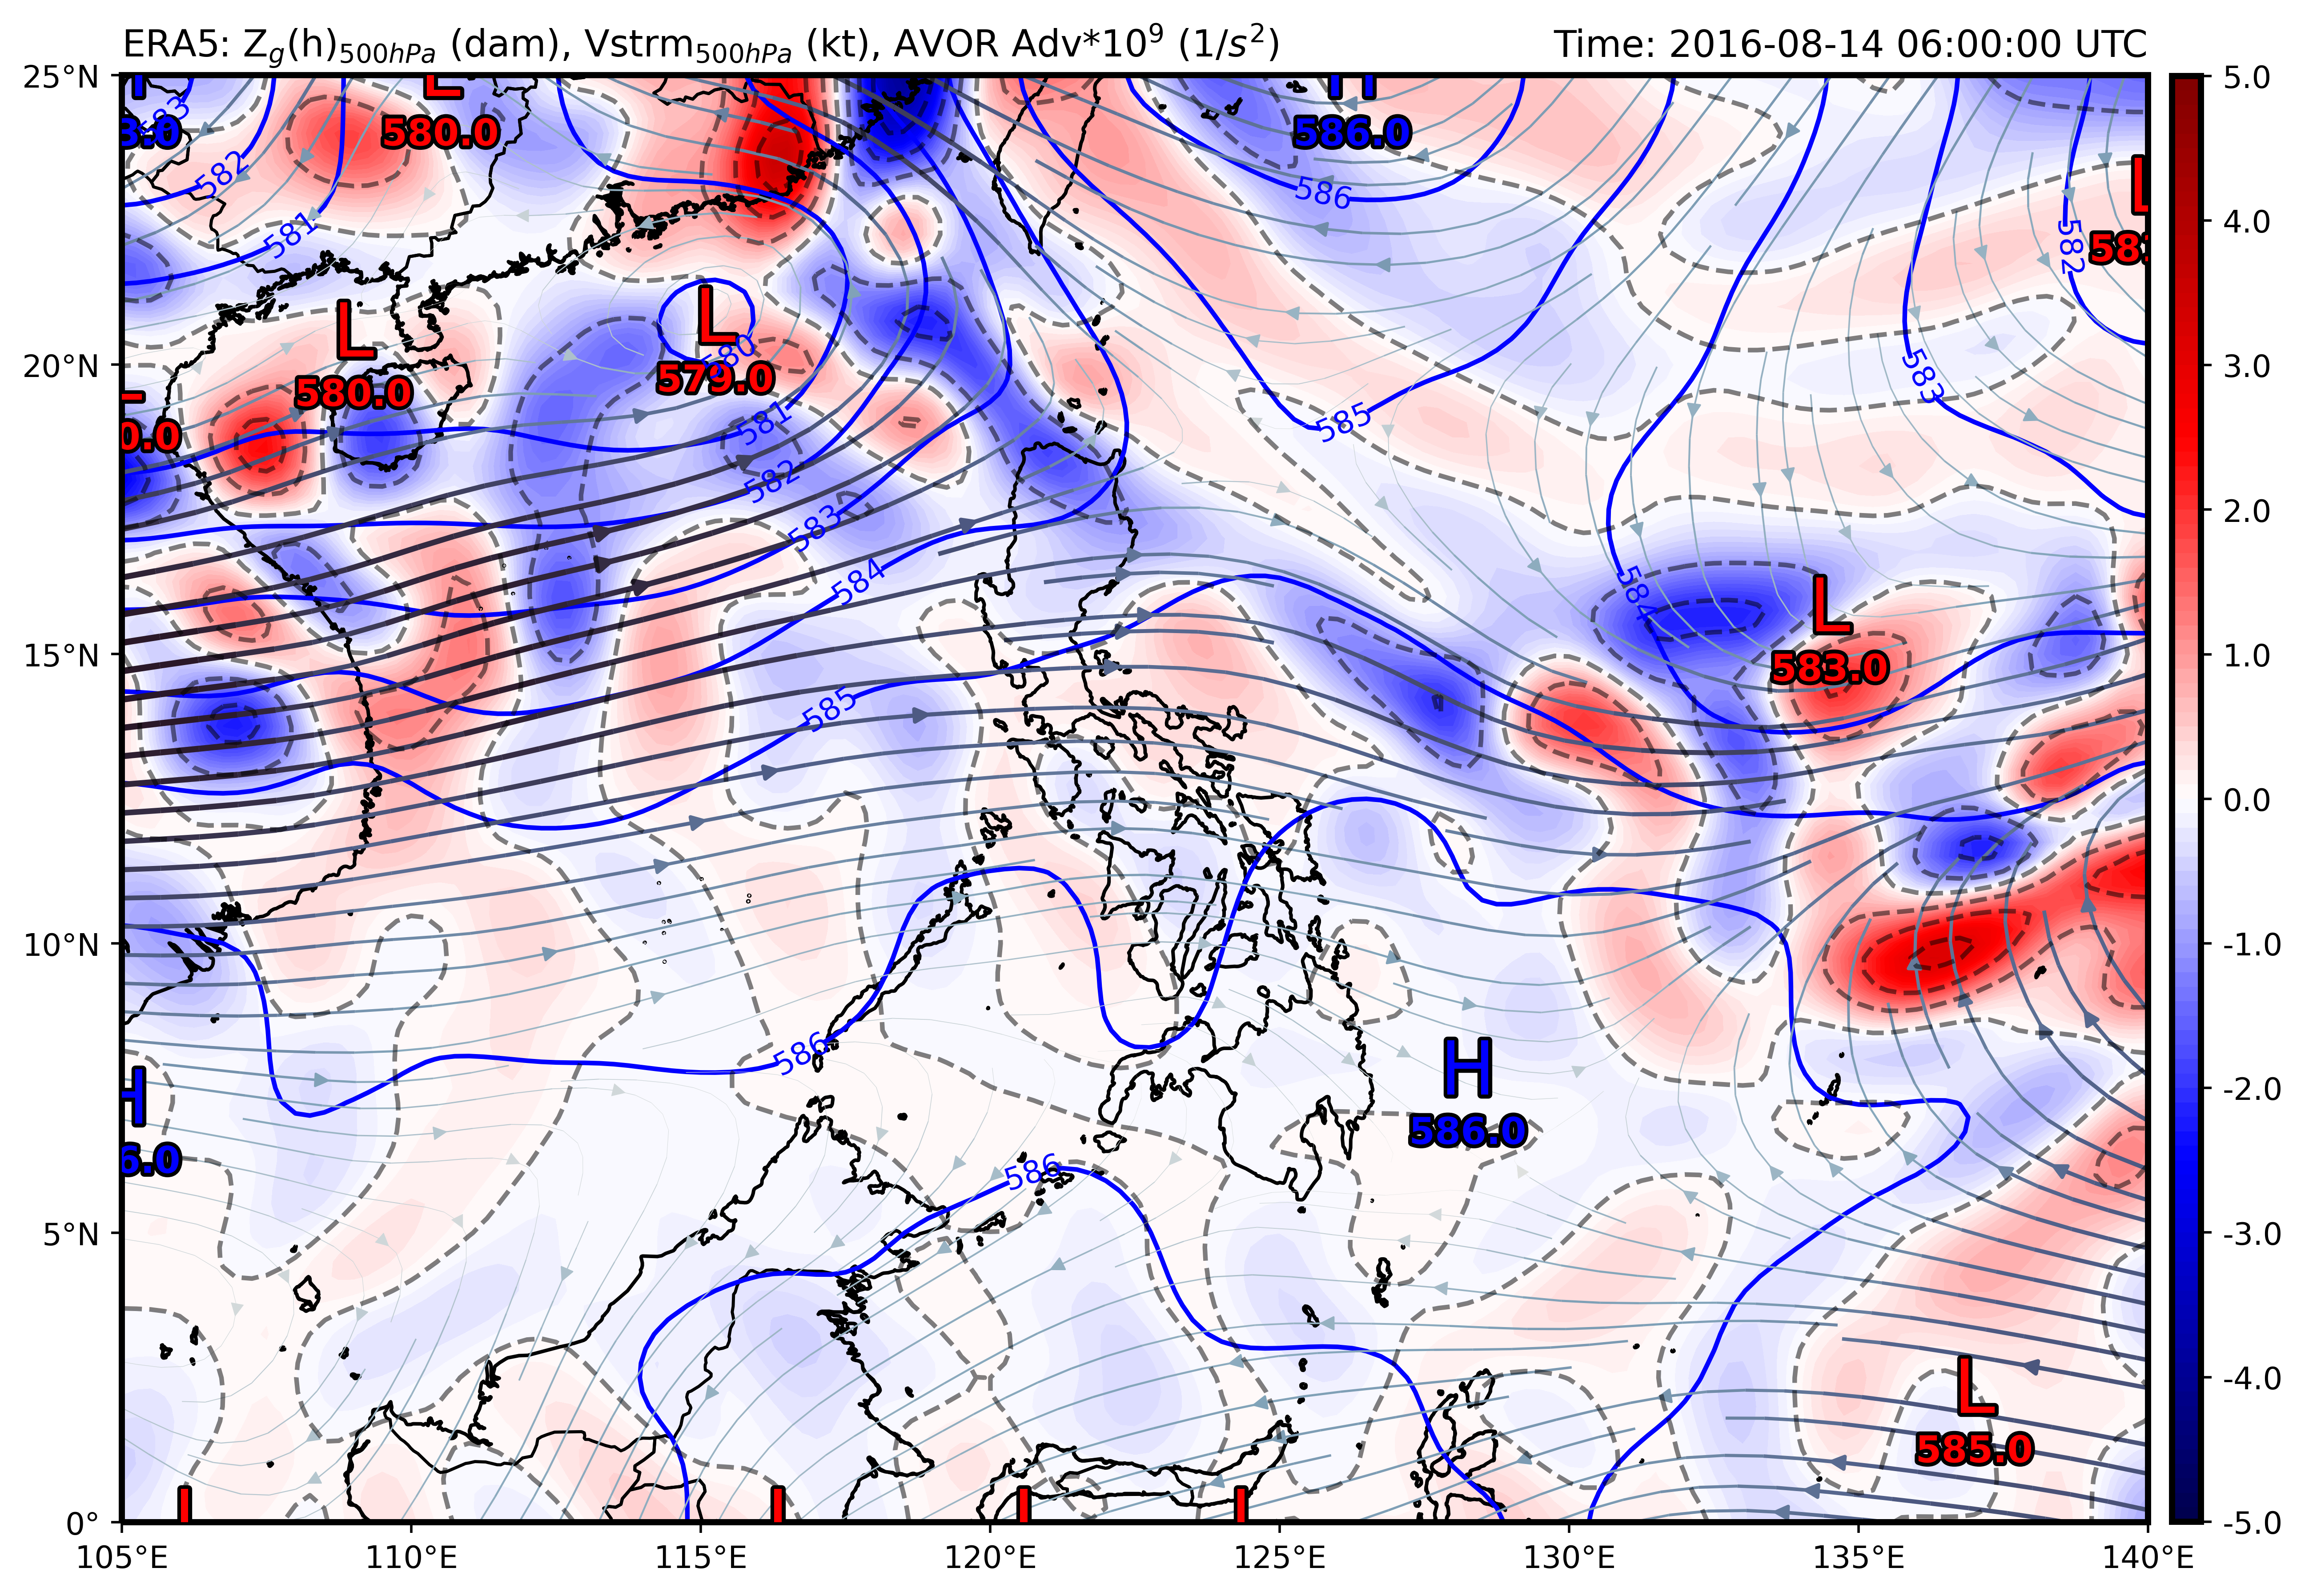

In [63]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Geopotential Heights in decameters
clevs_500_hght = np.arange(570, 590, 1) # For 500-hPa
cs = ax.contour(lons, lats, hght_dam, clevs_500_hght, colors='blue',
                transform=datacrs)
ax.clabel(cs, fmt='%d')

# Streamline Analysis
speed = np.array(sped_500)
n = np.clip(speed, 0, 35) #limit
lw = 2*speed / n.max()

strm = ax.streamplot(lons, lats, uwnd_500.to('kt').m, vwnd_500.to('kt').m, 
                     density =[1.75, 1.75], color = n, transform=datacrs, 
                     cmap = "swift.midnights_r", linewidth=lw)

# Plot Colorfill of Vorticity Advection
clev_avoradv = np.arange(-0.0000000050, 0.00000000501, 0.0000000001) # Colorfill
clev_avoradv1 = np.arange(-0.0000000040, 0.0000000041, 0.000000001) # Highlighting
fmt = '%1.9f'
cf = ax.contourf(lons, lats, vort_adv.m, clev_avoradv, cmap='seismic', transform=datacrs)
ax.contour(lons, lats, vort_adv.m, clev_avoradv1, colors='k', alpha=0.5, linestyles='dashed', 
           transform=datacrs)
cbar = plt.colorbar(cf, orientation='vertical', pad=0.01, aspect=50, shrink=0.542, 
                    ticks=[-0.0000000050, -0.0000000040,-0.0000000030,-0.0000000020,-0.0000000010, 
                           0.0000000000, 0.0000000010, 0.0000000020, 0.0000000030, 0.0000000040, 
                           0.0000000050], format=fmt)
cbar.ax.set_yticklabels(['-5.0','-4.0', '-3.0', '-2.0', '-1.0', 
                         '0.0', '1.0', '2.0', '3.0', '4.0', '5.0'])

# Plot Highs and Lows (Min/Max) values of Geopotential Height
plot_maxmin_points(lons, lats, hght_dam, 'max', 60, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, hght_dam, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5: Z$_{g}$(h)$_{500hPa}$ (dam), Vstrm$_{500hPa}$ (kt), AVOR Adv$*10^9$ ($1/s^{2}$)', 
          loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set X and Y-ticks for Latitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.minorticks_off()

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('Standard Geopotential Height.jpg', bbox_inches="tight")
plt.show()